In [44]:
import pandas as pd
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
import spacy
import string
from gensim.models.phrases import Phrases, Phraser
import pyLDAvis
import pyLDAvis.gensim
from gensim.utils import lemmatize
from pprint import pprint
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
%matplotlib inline
warnings.filterwarnings('ignore')

In [45]:
cnn_text = pd.read_csv("../data/cnn_text.csv")

In [46]:
cnn_text.head()

,Abstract,Title,clean_text
0,Hypoglycemic events are common and potentially...,Automatic Detection of Hypoglycemic Events Fro...,hypoglycemic event common potentially dangerou...
1,Triaging of outpatient referrals to ophthalmol...,Triaging ophthalmology outpatient referrals wi...,triage outpatient referral ophthalmology servi...
2,Advances in deep learning (DL) have been trans...,Applied Deep Learning in Plastic Surgery: Clas...,advance deep learn dl transformative computer ...
3,A substantial portion of medical data is unstr...,Clinical Data Extraction and Normalization of ...,substantial portion medical datum unstructured...
4,Data used for training of deep learning networ...,Structured report data can be used to develop ...,datum use training deep learning network usual...


In [100]:
stop_words = stopwords.words('english')
print(len(stop_words))
remove_words = ['overall', 'perform','attempts', 'model','use', 'calculating','performance','trainable',
                'data','result','representations','using','limited','used','feature','proposed','evaluate'
                ,'performance','algorithm','lr','ext','respective','respectively', 'accuracy', 'relatively'
                ,'small','challenge','validation','layer','better','three','detection','show','cnn','li', 
                'small','show','development','training','transfer','twos','cnns','pre','auroc','two','method',
                'parameters','segmentation','convolutional', 'neural', 'network', 'show','task','compare',
                'state','study', 'retrospective', 'datum','prediction','art','require', 'focus', 'base',
                'approach', 'paper', 'present', 'fall', 'due', 'recent', 'exponential', 'increase','analysis',
                'analysis','specificity','basis', 'function', 'kernel', 'area', 'curve', 'auc', 'may', 
                'useful','explore', 'two', 'different','test','models','system','deep', 'learning',
                'approach','require','may', 'useful','information', 'basis','obtain','methods','achieve',
                'level','al', 'research', 'grid', 'also','features', 'techniques', 'hard', 'parameter', 
                'sharing', 'cross', 'stitch', 'train', 'word', 'level', 'however','search', 'currently',
                'trained','article','analytic','datasets','fold', 'cross', 'propose','compared','based',
                'classification','results','dataset','multiple', 'time','architecture','end', 'sensitivity', 
                'specificity','proive','representation','input','technique','large','work','improve','layers',
                'set','learn','experiment','achieved','information','machine','offers', 'high','networks',
                'superior', 'classification', 'accuracy', 'for', 'automated', 'coding', 'support', 'aid', 'address',
               'available','https','important','role', 'application','good','rate','field','new','tool',
               'subject','value','map','quality','application','provide','one','mr', 'false','positive','tune','fine',
                'github','com','precision','recall','long','short','gold', 'standard','problem','demonstrate','apply',
                'well','truth','ground','similarity','coefficient','entity','event','cohort','molecular','goal','knowledge',
                'refer','conditional','name','natural','language','metho','processing','nlp','term']

#identifies and removes duplicates and returns a lits of words
remove_words= list(set(remove_words))
stop_words.extend(remove_words)
print(len(remove_words))
print(len(stop_words))

179
196
375


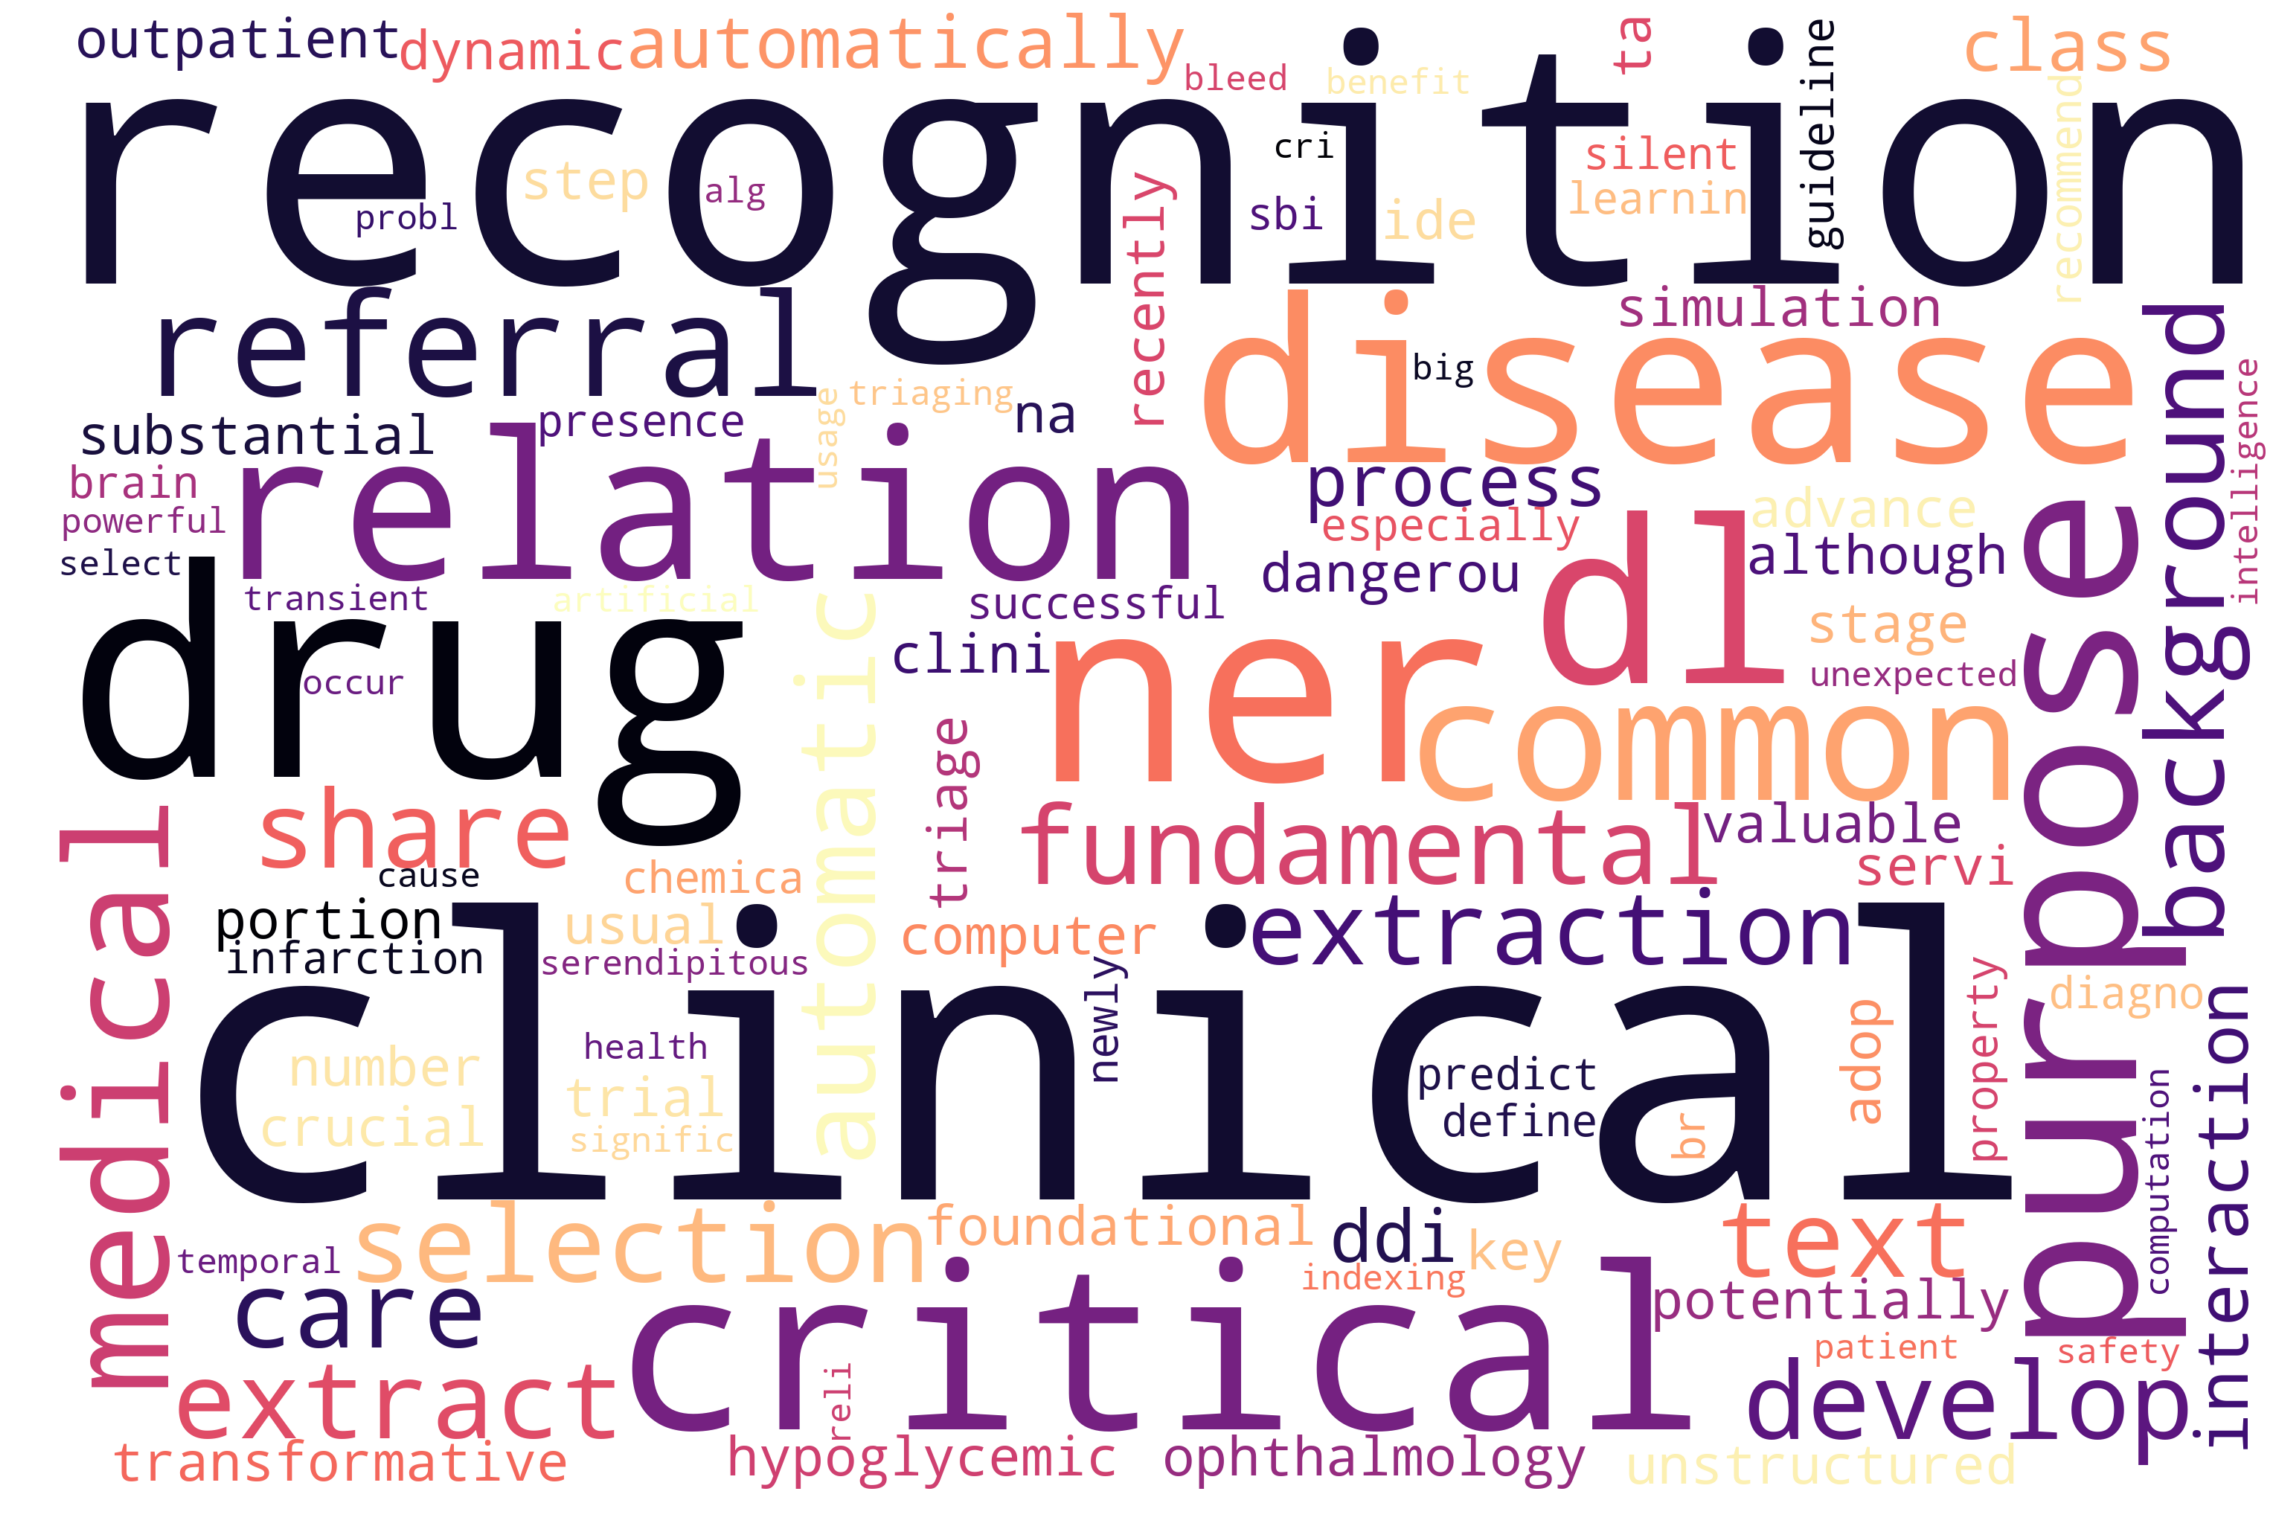

In [101]:
#Word cloud of 100 words in the entire clean text
wordcloud = WordCloud(width = 3000,
    height = 2000,background_color='white',colormap=plt.cm.magma,
                          stopwords=stop_words,
                          max_words=100,
                           
                          random_state=42,collocations=False
                         ).generate(str(cnn_text.clean_text))

#print(wordcloud)
plt.figure(figsize = (40, 30), edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
#plt.savefig("../data/word_cloud.png")
plt.show()

In [102]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
minus_stopwords = remove_stopwords(cnn_text.clean_text)

In [103]:
clean_text = [" ".join(x) for x in minus_stopwords]

In [104]:
def text_to_words(text):
    for sentence in text:
        yield(gensim.utils.simple_preprocess(str(sentence)))  # deacc=True removes punctuations

words_text = list(text_to_words(clean_text))

print(words_text[3])

['substantial', 'portion', 'medical', 'unstructured', 'extract', 'unstructured', 'text', 'barrier', 'advance', 'clinical', 'patient', 'care', 'addition', 'ongoing', 'predominately', 'english', 'whereas', 'inflect', 'non', 'latin', 'alphabet', 'slavic', 'cyrillic', 'alphabet', 'numerous', 'linguistic', 'develop', 'automatically', 'extract', 'biomarker', 'status', 'patient', 'breast', 'cancer', 'oncology', 'center', 'bulgaria', 'dual', 'embedding', 'english', 'bulgarian', 'encode', 'syntactic', 'polarity', 'embedding', 'subsequently', 'align', 'vector', 'space', 'embedding', 'recurrent', 'derive', 'biomarker', 'status', 'estrogen', 'receptor', 'progesterone', 'receptor', 'human', 'epidermal', 'growth', 'factor', 'receptor', 'resolve', 'ambiguity', 'highly', 'variable', 'medical', 'text', 'contain', 'latin', 'cyrillic', 'text', 'final', 'incorporate', 'english', 'bulgarian', 'syntax', 'polarity', 'embedding', 'score', 'estrogen', 'receptor', 'progesterone', 'receptor', 'human', 'epidermal

In [105]:
#clean_text = [" ".join(x) for x in minus_stopwords]

                         Bigram      Freq
0                     free text  6.239966
1                 clinical note  5.201141
2                 clinical text  4.819048
3               recognition ner  4.546809
4               computer vision  4.480556
5           attention mechanism  4.247487
6           relation extraction  3.981768
7                 random forest  3.883233
8             electronic health  3.117101
9                 health record  3.117101
10  supplementary bioinformatic  3.115943
11         bioinformatic online  3.115943


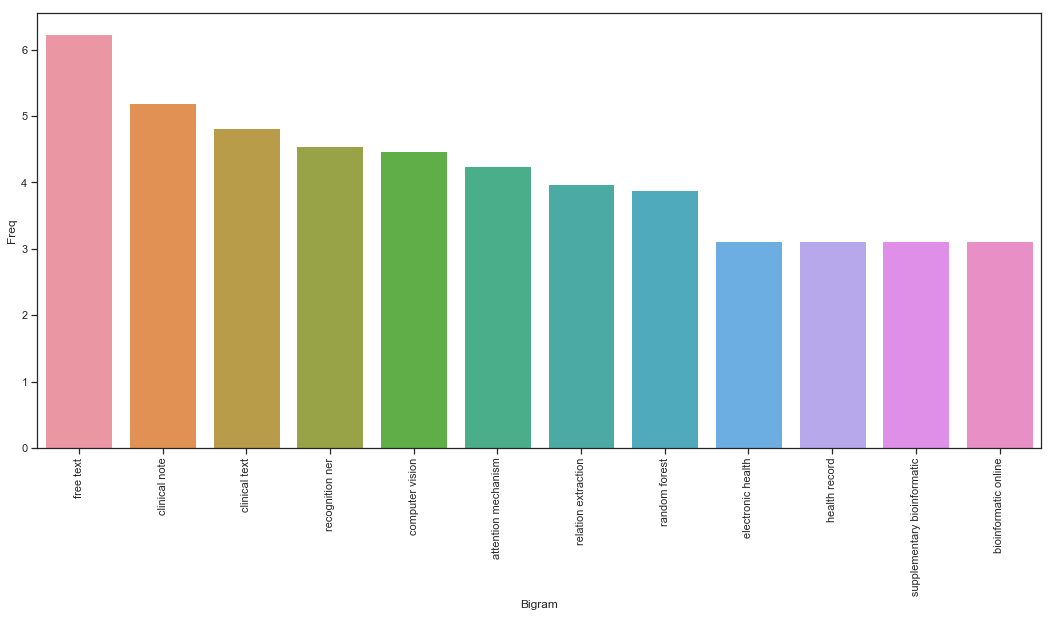

In [106]:
#Most frequently occuring bigrams in the data. plot both bar plot and word cloud of bigrams in the data 
def top_bi_grams(clean_text, n=None):
    clean_text = [" ".join(x) for x in minus_stopwords]
    vectorizer = TfidfVectorizer(ngram_range = (2,2), min_df = 5,stop_words=stop_words).fit(clean_text)
    bows = vectorizer.transform(clean_text)
    sumwords = bows.sum(axis=0) 
    words_freq = [(word, sumwords[0, idx]) for word, idx in     
                  vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top_bigrams = top_bi_grams(clean_text, n=50)
top_bigrams_df = pd.DataFrame(top_bigrams)
top_bigrams_df.columns=["Bigram", "Freq"]
print(top_bigrams_df)

#Barplot of most freq Bi-grams
sns.set(rc={'figure.figsize':(18,8)}, style ='white' )
sns.set_style("ticks")

h=sns.barplot(x="Bigram", y="Freq", data=top_bigrams_df)
h.set_xticklabels(h.get_xticklabels(), rotation=90);

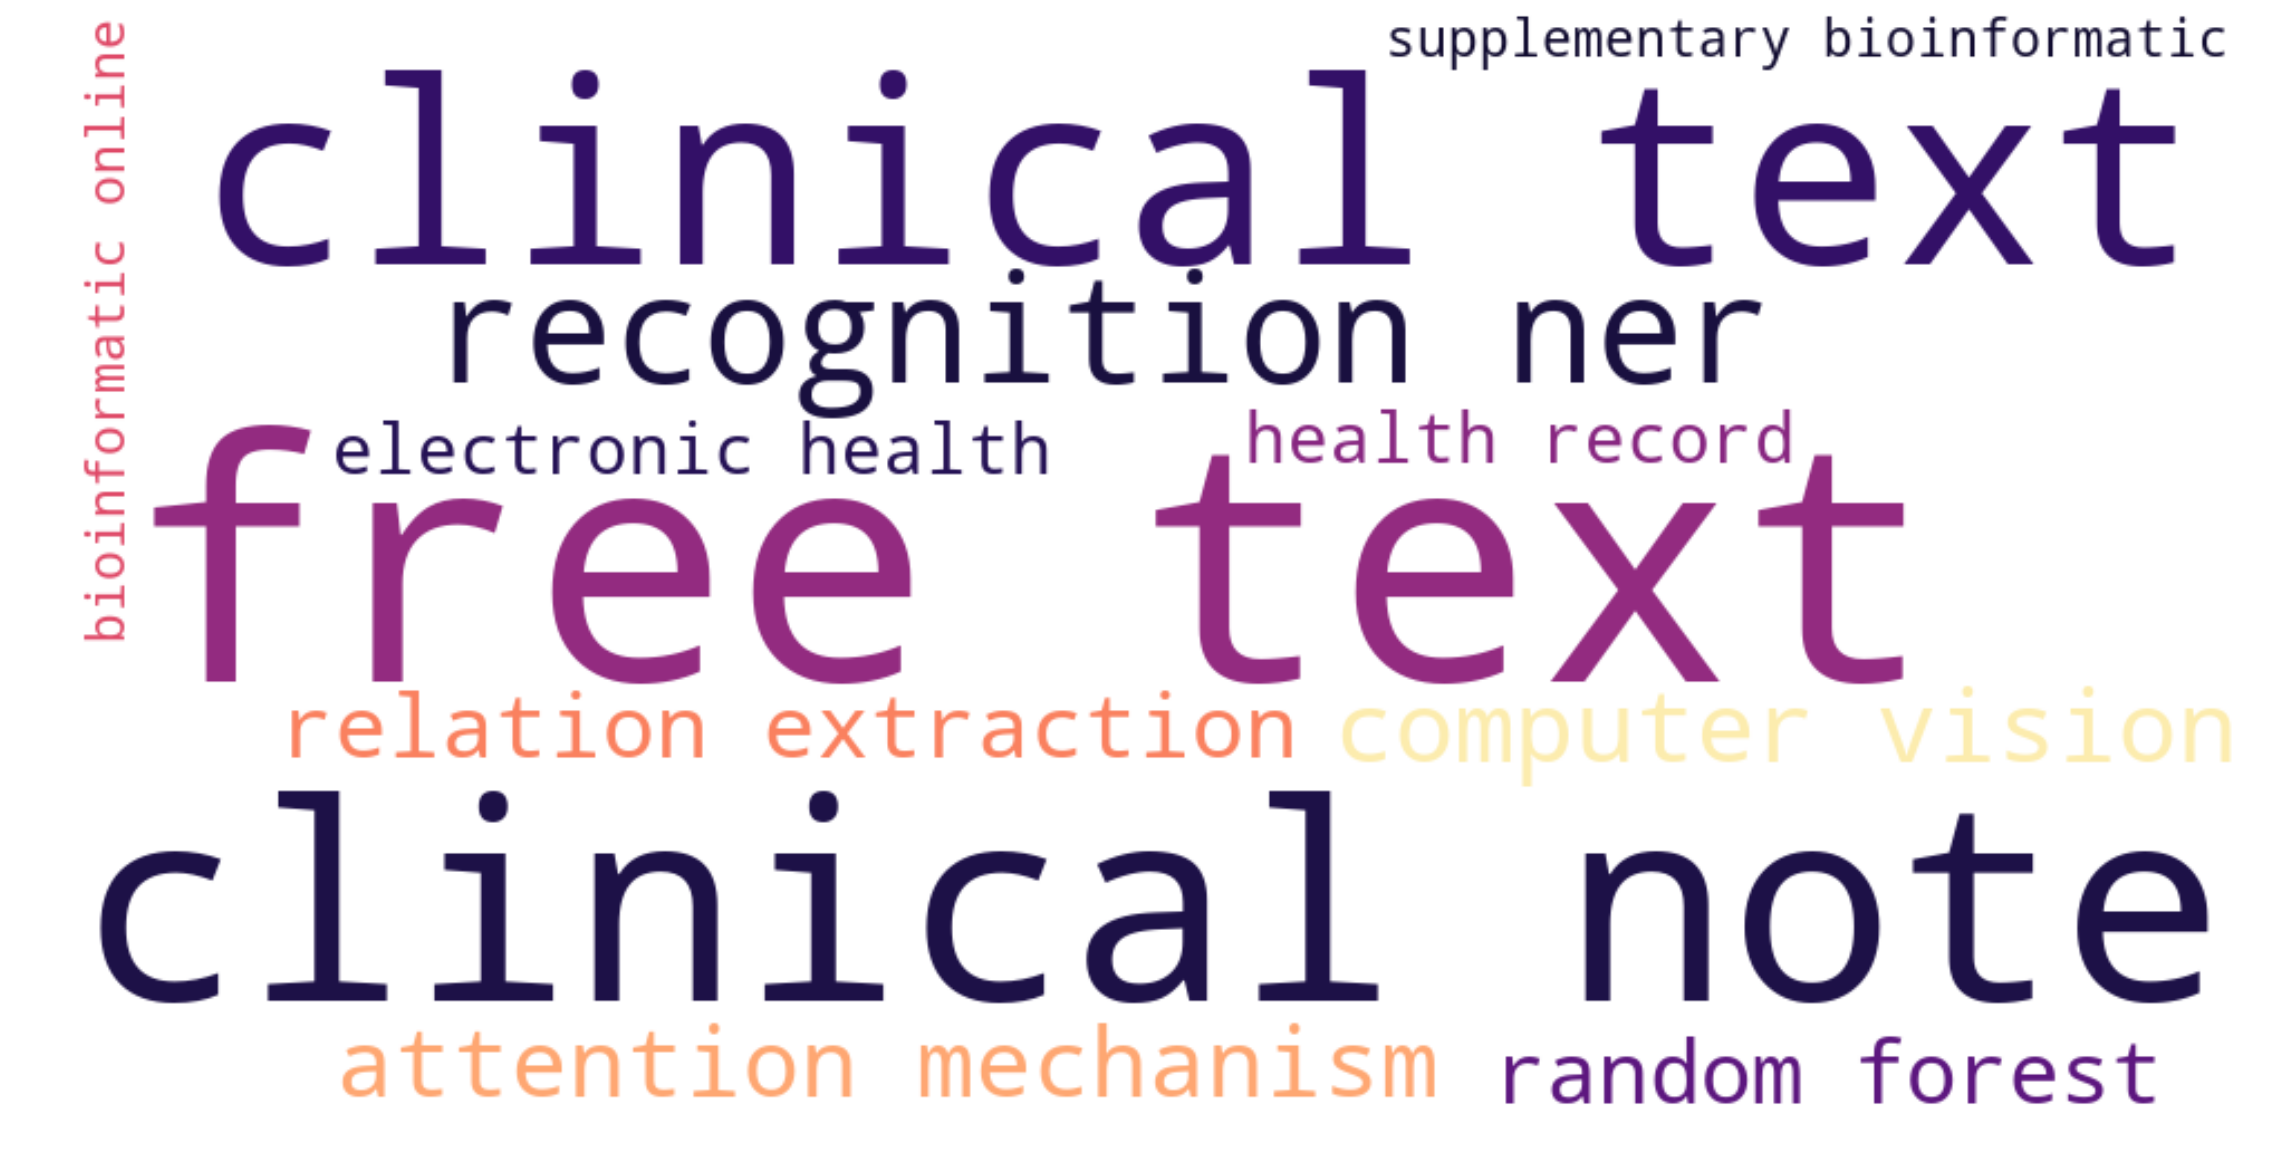

In [134]:
bigrams = {}
for w, x in top_bigrams_df.values:
    bigrams[w] = x
wordcloud = WordCloud(width = 1000,
    height = 500,background_color='white',colormap=plt.cm.magma,margin=5,
                     min_word_length =2, relative_scaling=1, collocations=False)
wordcloud.generate_from_frequencies(bigrams)
plt.figure(figsize = (40, 30),
    
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("../data/word_cloud_cnn_text.png")
plt.show()

In [116]:
bigram = Phrases(minus_stopwords, min_count=1, threshold=100)
trigram = Phrases(minus_stopwords, min_count=1, threshold=100)
bigrams_mod = Phraser(bigram)
trigrams_mod = Phraser(trigram)

In [117]:
def bigrams(texts):
    return [bigrams_mod[doc] for doc in texts]
words_bigrams = bigrams(minus_stopwords)

def trigrams(texts):
    return [trigrams_mod[doc] for doc in texts]
words_trigrams = trigrams(minus_stopwords)

In [118]:
nlp = spacy.load('en', disable=['parser', 'ner'])

In [119]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [120]:
data_lemme = lemmatization(words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [121]:
# Create Dictionary
id2word = corpora.Dictionary(words_bigrams)


# Create Corpus
texts = words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:2])


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 3), (22, 1), (23, 1), (24, 1), (25, 1), (26, 4), (27, 3), (28, 2), (29, 1), (30, 1), (31, 3), (32, 2), (33, 1), (34, 4), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 2), (49, 1), (50, 1)], [(7, 1), (12, 1), (16, 1), (34, 1), (40, 1), (51, 1), (52, 1), (53, 3), (54, 2), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 3), (62, 3), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 5), (79, 1), (80, 1), (81, 2), (82, 2), (83, 1), (84, 1), (85, 1), (86, 2), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 4), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 2), (99, 1), (100, 1), (101, 1), (102, 3), (103, 2), (104, 1), (105, 1)]]


In [122]:
id2word[76]

'maintenance'

In [126]:
# Build LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=18, 
                     random_state=100,
                     update_every=1,
                     chunksize=1000,
                     passes=25,
                     alpha='auto',
                     per_word_topics=True)

In [127]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.018*"share" + 0.016*"score" + 0.013*"record" + 0.012*"text" + '
  '0.012*"clinical" + 0.012*"medical" + 0.012*"electronic" + 0.012*"semantic" '
  '+ 0.010*"decision" + 0.010*"predict"'),
 (1,
  '0.001*"hla" + 0.001*"report" + 0.001*"clinical" + 0.001*"bind" + '
  '0.001*"classifier" + 0.001*"protein" + 0.001*"many" + 0.001*"radiology" + '
  '0.001*"develop" + 0.001*"self"'),
 (2,
  '0.039*"extraction" + 0.031*"relation" + 0.031*"ddi" + 0.028*"drug" + '
  '0.021*"text" + 0.019*"clinical" + 0.013*"interaction" + 0.013*"sequence" + '
  '0.011*"protein" + 0.011*"many"'),
 (3,
  '0.021*"character" + 0.014*"patient" + 0.014*"hype" + 0.014*"medical" + '
  '0.011*"sentence" + 0.011*"mi" + 0.011*"mean_sd" + 0.011*"hypoglycemia" + '
  '0.011*"ehr" + 0.011*"semantic"'),
 (4,
  '0.019*"report" + 0.019*"label" + 0.017*"disease" + 0.016*"embed" + '
  '0.014*"structure" + 0.014*"chinese_emrs" + 0.011*"medical" + '
  '0.009*"radiograph" + 0.009*"crf" + 0.009*"particularly"'),
 (5,
  '0.033*"

In [128]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.251728664805549

Coherence Score:  0.3711723558813984


In [129]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

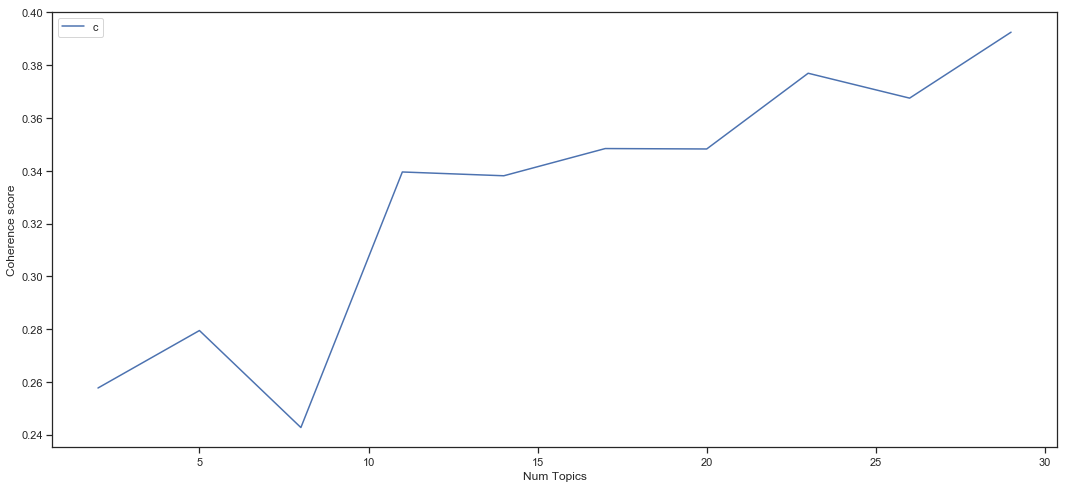

In [130]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=words_bigrams, start=2, limit=30, step=3)
# Show graph

limit=30; start=2; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [131]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
17    -0.069244  0.148894       1        1  9.121310
9     -0.028061  0.057005       2        1  8.372248
12    -0.076764  0.106773       3        1  8.228899
2      0.171476  0.010462       4        1  7.991558
7      0.103986  0.069719       5        1  7.432888
14     0.116730 -0.067581       6        1  7.336924
11    -0.108778 -0.136914       7        1  7.258468
4      0.015583 -0.104168       8        1  6.969448
16    -0.137700 -0.031754       9        1  6.111195
6     -0.048953  0.016667      10        1  5.695592
10     0.062422 -0.054743      11        1  5.177181
5      0.018702  0.110778      12        1  4.922339
0      0.093597  0.005521      13        1  4.835298
15    -0.038543 -0.066182      14        1  4.373853
3      0.021795 -0.032077      15        1  3.896096
13    -0.035661 -0.018945      16        1  1.939135
8     -0.022729 -0.005553      17        1  0.319880
1     -0.037857 -0.007901      18        1  0.017685, topic_info=     Category       Freq        Term      Total  loglift  logprob
253   Default  38.000000      report  38.000000  30.0000  30.0000
324   Default  24.000000    relation  24.000000  29.0000  29.0000
285   Default  12.000000         ddi  12.000000  28.0000  28.0000
216   Default  31.000000        text  31.000000  27.0000  27.0000
301   Default  24.000000  extraction  24.000000  26.0000  26.0000
...       ...        ...         ...        ...      ...      ...
719   Topic18   0.000518        rule  25.210110  -2.1531  -7.4179
759   Topic18   0.000518         vec   4.702097  -0.4739  -7.4180
72    Topic18   0.000518     include  15.595663  -1.6729  -7.4180
208   Topic18   0.000518       score  26.687223  -2.2102  -7.4181
1638  Topic18   0.000518      immune   2.194180   0.2882  -7.4181

[1039 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1230      6  0.884121    abstract
1343      5  0.680258  accessible
53        2  0.159128  accurately
53        3  0.477383  accurately
53        8  0.159128  accurately
...     ...       ...         ...
341       6  0.315939        year
50        1  0.184823       yield
50        2  0.369647       yield
50        6  0.184823       yield
50       15  0.184823       yield

[1605 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 10, 13, 3, 8, 15, 12, 5, 17, 7, 11, 6, 1, 16, 4, 14, 9, 2])

In [132]:
pyLDAvis.save_html(vis, '../data/lda_text.html')